# Kinematic afterslip on 3D fault surface (synthetic)
- Derived from: https://github.com/brendanjmeade/kinematic_afterslip/blob/main/kinematic_afterslip_strike_slip.ipynb
- Required libraries:
  - matplotlib
  - numpy
  - scipy
  - cmcrameri: https://pypi.org/project/cmcrameri/
  - skies: https://github.com/brendanjmeade/skies

- Required files:
  - `param.json`
  - `nankai_mesh_parameters.json`
  - `nankai.msh`

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cmcrameri.cm as cmc
from scipy.interpolate import griddata
import skies

%config InlineBackend.figure_format = "retina"

# Read in plotting parameters and mesh geometry

In [2]:
params_file_name = "params.json"
meshes_parameters_file_name = "nankai_mesh_parameters.json"

# Read params.  Only used for plotting limits here.
params = skies.get_params(params_file_name)

# Read mesh information.  Only used for mesh geometry here.
meshes = skies.read_meshes(meshes_parameters_file_name)

Warning: The file contains tag data that couldn't be processed.

# Define plotting function

In [3]:
def contour_plot_mesh(mesh, fill_value, levels, title_string, colorbar_label):
    x_vec = np.linspace(
        params.min_longitude, params.max_longitude, params.n_grid_longitude
    )
    y_vec = np.linspace(
        params.min_latitude, params.max_latitude, params.n_grid_latitude
    )
    x_mat, y_mat = np.meshgrid(x_vec, y_vec)
    centroids_lon = mesh.centroids[:, 0]
    centroids_lat = mesh.centroids[:, 1]
    fill_value_mat = griddata(
        (centroids_lon, centroids_lat), fill_value, (x_mat, y_mat), method="cubic"
    )
    inpolygon_vals = skies.inpolygon(x_mat, y_mat, mesh.x_perimeter, mesh.y_perimeter)
    inpolygon_vals = np.reshape(
        inpolygon_vals, (params.n_grid_longitude, params.n_grid_latitude)
    )
    fill_value_mat[~inpolygon_vals] = np.nan
    cmap = cmc.hawaii_r
    chf = plt.contourf(
        x_mat, y_mat, fill_value_mat, cmap=cmap, levels=levels, extend="both"
    )
    plt.colorbar(chf, fraction=0.026, pad=0.04, label=colorbar_label)
    ch = plt.contour(
        x_mat,
        y_mat,
        fill_value_mat,
        colors="k",
        linestyles="solid",
        linewidths=0.25,
        levels=levels,
    )
    plt.plot(mesh.x_perimeter, mesh.y_perimeter, "-k", linewidth=1.0)
    plt.gca().set_aspect("equal", adjustable="box")
    plt.gca().set_facecolor("gainsboro")
    # plt.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, "-k")
    plt.title(title_string)

# Generated synthetic accmulated slip and synthetic coseismic slip

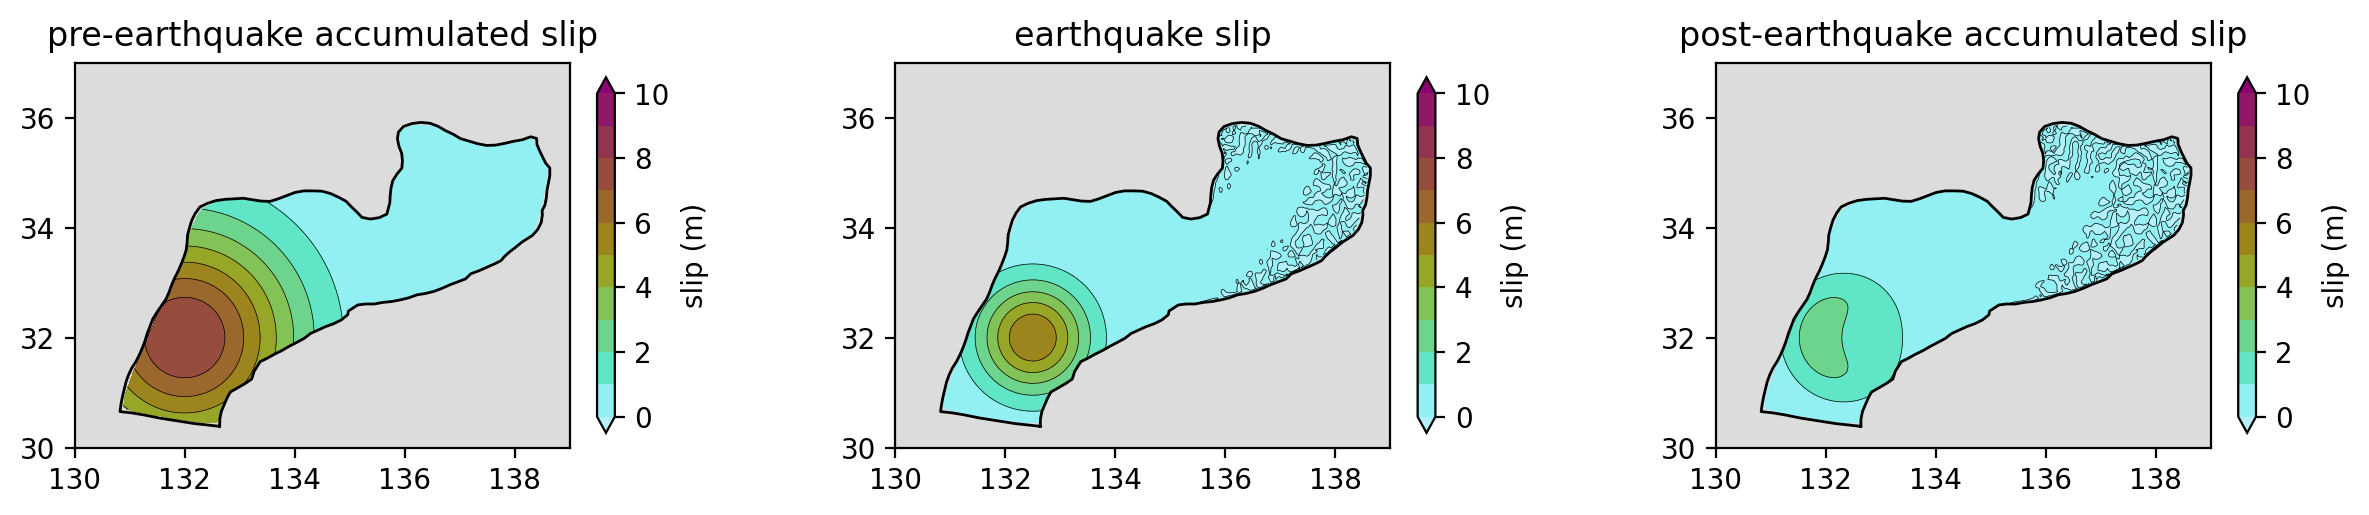

In [15]:
# Accumulated slip (synthetic Gaussian)
lon_centroid_accumulation = 132.0
lat_centroid_accumulation = 32.0
width_centroid_accumulation = 2.0
magnitude_accumulation = 8.0
tri_centroid_to_mesh_lon = meshes[0].centroids[:, 0] - lon_centroid_accumulation
tri_centroid_to_mesh_lat = meshes[0].centroids[:, 1] - lat_centroid_accumulation
tri_centroid_to_mesh_centroid_distance = np.sqrt(
    tri_centroid_to_mesh_lon**2 + tri_centroid_to_mesh_lat**2
)
accumulated_slip = magnitude_accumulation * np.exp(
    -((tri_centroid_to_mesh_centroid_distance / width_centroid_accumulation) ** 2.0)
)


# Earthquake slip (synthetic Gaussian)
lon_centroid_coseismic = 132.5
lat_centroid_coseismic = 32.0
width_centroid_coseismic = 1.0
magnitude_coseismic = 6.0
tri_centroid_to_mesh_lon = meshes[0].centroids[:, 0] - lon_centroid_coseismic
tri_centroid_to_mesh_lat = meshes[0].centroids[:, 1] - lat_centroid_coseismic
tri_centroid_to_mesh_centroid_distance = np.sqrt(
    tri_centroid_to_mesh_lon**2 + tri_centroid_to_mesh_lat**2
)
coseismic_slip = magnitude_coseismic * np.exp(
    -((tri_centroid_to_mesh_centroid_distance / width_centroid_coseismic) ** 2.0)
)

# Post-earthquake accumulated slip
residual_slip = accumulated_slip - coseismic_slip

# TODO: This is the place for distance modulation filter
# (e.g. effective afterslip triggering distance)
# Earthquake slip (synthetic Gaussian)
lon_centroid_coseismic = 132.5
lat_centroid_coseismic = 32.0
width_centroid_coseismic = 1.0
magnitude_coseismic = 1.0
tri_centroid_to_mesh_lon = meshes[0].centroids[:, 0] - lon_centroid_coseismic
tri_centroid_to_mesh_lat = meshes[0].centroids[:, 1] - lat_centroid_coseismic
tri_centroid_to_mesh_centroid_distance = np.sqrt(
    tri_centroid_to_mesh_lon**2 + tri_centroid_to_mesh_lat**2
)
distance_filter = magnitude_coseismic * np.exp(
    -((tri_centroid_to_mesh_centroid_distance / width_centroid_coseismic) ** 2.0)
)
residual_slip *= distance_filter


# Plot slip pre-, co-, and post-seismic slip distributions
plt.figure(figsize=(15, 2.5))
plt.subplot(1, 3, 1)
contour_plot_mesh(
    meshes[0],
    accumulated_slip,
    np.linspace(0, 10, 11),
    "pre-earthquake accumulated slip",
    "slip (m)",
)
plt.subplot(1, 3, 2)
contour_plot_mesh(
    meshes[0], coseismic_slip, np.linspace(0, 10, 11), "earthquake slip", "slip (m)"
)
plt.subplot(1, 3, 3)
contour_plot_mesh(
    meshes[0],
    residual_slip,
    np.linspace(0, 10, 11),
    "post-earthquake accumulated slip",
    "slip (m)",
)
plt.show()

# Generated afterslip sequence

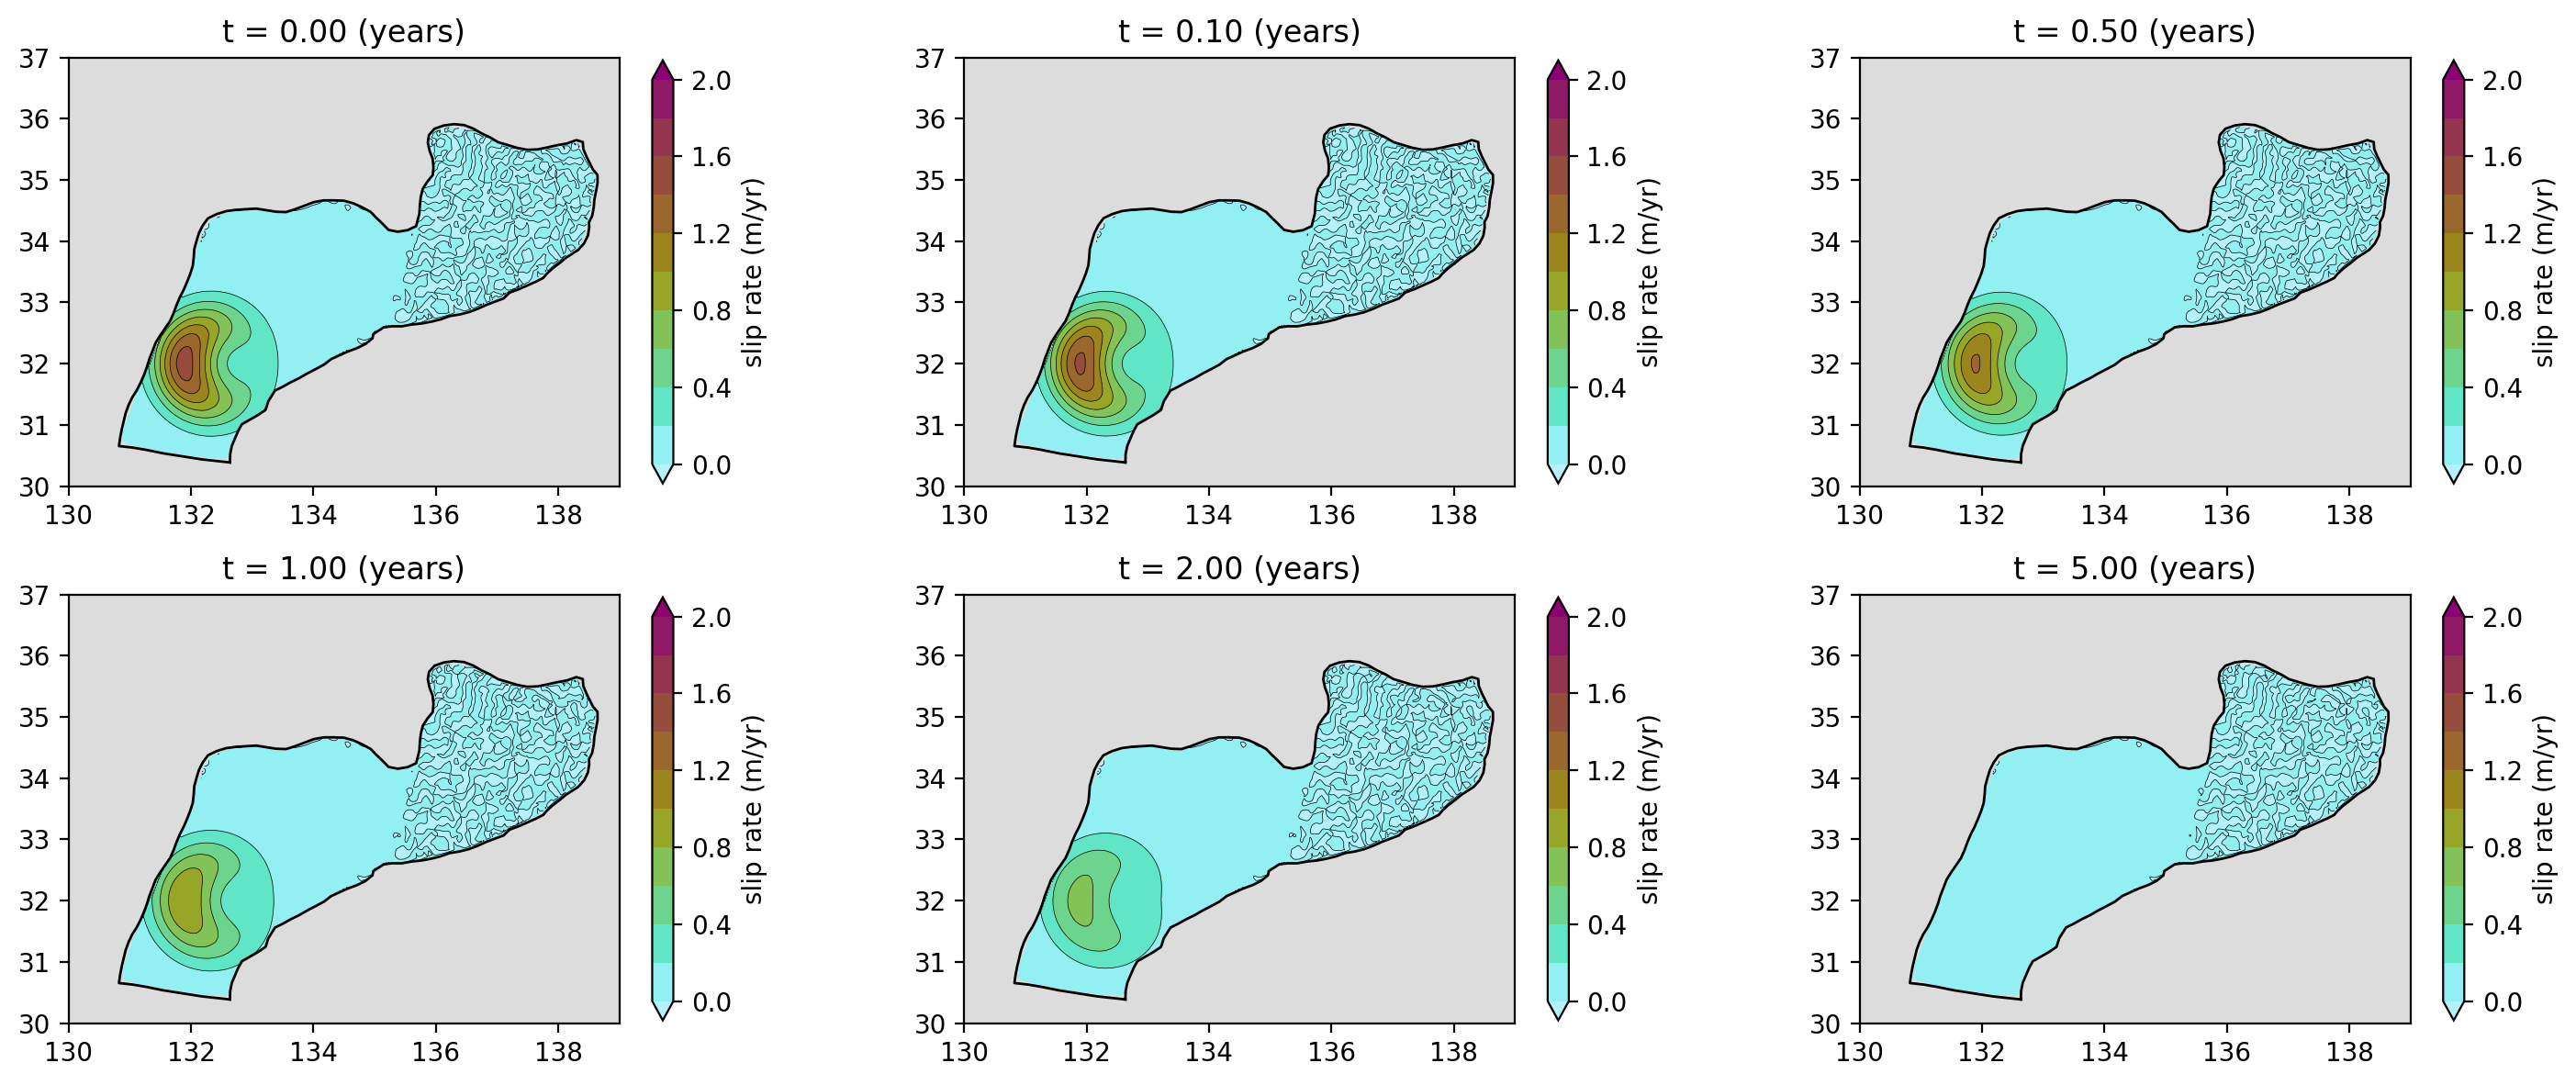

In [16]:
# Assumed functional forms for kinematic afterslip model
def calc_V(c, gamma, m_coseismic, g, h, f):
    numerator = c**2 * gamma * m_coseismic
    denominator = np.sum(g * h / f)
    V = numerator / denominator
    return V


def calc_v0(V, g, h):
    v0 = V * g * h
    return v0


def calc_m_afterslip(gamma, m_coseismic, g, h, f):
    numerator = gamma * g * h * m_coseismic
    denominator = f * np.sum(g * h / f)
    m_afterslip = numerator / denominator
    return m_afterslip


# Constants
Y2S = 365.25 * 24 * 60 * 60
MIN_GEOMETRIC_MOMENT = 1e-10

# Normalize moments
element_areas = np.mean(meshes[0].areas)
n_fault_pts = meshes[0].n_tde
coseismic_geometric_moment = coseismic_slip * element_areas
residual_geometric_moment = residual_slip * element_areas
residual_geometric_moment[residual_geometric_moment < MIN_GEOMETRIC_MOMENT] = (
    MIN_GEOMETRIC_MOMENT
)
m_coseismic = np.sum(coseismic_geometric_moment / element_areas)

# Core kinematic afterslip model parameters
gamma = 0.075e9
c = 0.65e-12
f = residual_geometric_moment
g = residual_geometric_moment**2.0
h = m_coseismic

# Initial conditions
V = calc_V(c, gamma, m_coseismic, g, h, f)
v0 = calc_v0(V, g, h)

# Afterslip evaluation times
t = np.array([0, 0.1, 0.5, 1.0, 2.0, 5.0]) * Y2S

# Calculate afterslip velocities at specified times
v = np.zeros((n_fault_pts, len(t)))
for i in range(len(t)):
    v[:, i] = v0 * np.exp(-(c**2.0) * f * element_areas * t[i])

# Convert from m/s to m/yr
v = v * Y2S

# Plot afterslip velocities in time
plt.figure(figsize=(15, 6))
for i in range(len(t)):
    plt.subplot(2, 3, i + 1)
    contour_plot_mesh(
        meshes[0],
        v[:, i],
        np.linspace(0, 2, 11),
        f"t = {t[i]/Y2S:0.2f} (years)",
        "slip rate (m/yr)",
    )
plt.tight_layout()
plt.show()